In [1]:
# Import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
data = "https://raw.githubusercontent.com/Daven254/mlbookcamp-code/master/chapter-02-car-price/data_week2.csv"
!wget $data

--2022-06-20 16:41:20--  https://raw.githubusercontent.com/Daven254/mlbookcamp-code/master/chapter-02-car-price/data_week2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8002::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data_week2.csv.15’

data_week2.csv.15   100%[===================>]   1.41M  3.98MB/s    in 0.4s    

2022-06-20 16:41:21 (3.98 MB/s) - ‘data_week2.csv.15’ saved [1475504/1475504]



In [10]:
def load_and_remove_spaces(data):
    # making the data readable consistently
    df = pd.read_csv(data)
    df.columns = df.columns.str.lower().str.replace(' ','_') 
    strings = list(df.dtypes[df.dtypes == 'object'].index)

    for col in strings:
        df[col] = df[col].str.lower().str.replace(' ','_') 

    return df

In [12]:
df = load_and_remove_spaces(data)

EDA

In [14]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


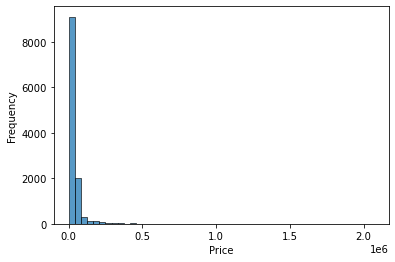

In [13]:
sns.histplot(df['msrp'],bins = 50)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()
plt.close()

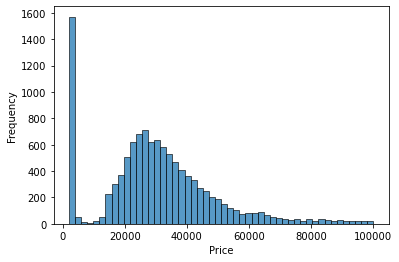

In [15]:
sns.histplot(df.msrp[df.msrp < 100000], bins=50)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.show()
plt.close()

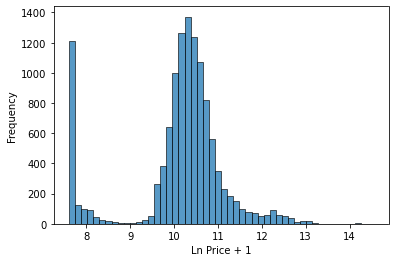

In [16]:
sns.histplot(np.log1p(df['msrp']),bins = 50)
plt.xlabel('Ln Price + 1')
plt.ylabel('Frequency')
plt.show()

In [17]:
# checking for NA values for each column and counting them
df.isna().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

# Setting up each df 
(train, validation, and test dataframes)

In [18]:
np.random.seed(4)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [19]:
y_train_orig = df_train['msrp'].values
y_val_orig = df_val['msrp'].values
y_test_orig = df_test['msrp'].values

y_train = np.log1p(df_train['msrp'].values)
y_val = np.log1p(df_val['msrp'].values)
y_test = np.log1p(df_test['msrp'].values)

del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

In [25]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

# Linear Regression Modeling

In [20]:
def train_linear_regression(X,y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones,X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0],w[1:]

In [29]:
# accounting for number of doors on the car and the make
# accounting for fuel type
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')

    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)
        
    #for v in top_20_make:
    #    feature = 'is_make_%s' % v
    #    df[feature] = (df['make'] == v).astype(int)
    #    features.append(feature)
    
    #for v in fuel_types:
    #    feature = 'is_fuel_%s' % v
    #    df[feature] = (df['engine_fuel_type'] == v).astype(int)
    #    features.append(feature)
        
    for c, values in category.items():
        for v in values:
            df['%s_%s' % (c,v)] = (df[c] == v).astype('int')
            features.append('%s_%s' % (c,v))

            

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [23]:
def rmse(y,y_pred):
    diff = y-y_pred
    diff_squared = diff**2
    mse = diff_squared.mean()
    return mse

In [31]:
category_columns = ['make','engine_fuel_type','transmission_type', 'driven_wheels', 'market_category', 'vehicle_size','vehicle_style']
category = {}
for x in category_columns:
    fields = len(df_train[x].value_counts().index)
    if fields > 20:
        fields = 20
    category[x] = df_train[x].value_counts().head(fields).index
    print(df_train[x].value_counts().head(fields).index,fields)



Index(['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge', 'nissan', 'gmc',
       'honda', 'mazda', 'cadillac', 'bmw', 'mercedes-benz', 'suzuki',
       'infiniti', 'volvo', 'audi', 'hyundai', 'subaru', 'acura',
       'mitsubishi'],
      dtype='object') 20
Index(['regular_unleaded', 'premium_unleaded_(required)',
       'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)', 'diesel',
       'electric', 'flex-fuel_(premium_unleaded_required/e85)',
       'flex-fuel_(premium_unleaded_recommended/e85)',
       'flex-fuel_(unleaded/natural_gas)', 'natural_gas'],
      dtype='object') 10
Index(['automatic', 'manual', 'automated_manual', 'direct_drive', 'unknown'], dtype='object') 5
Index(['front_wheel_drive', 'rear_wheel_drive', 'all_wheel_drive',
       'four_wheel_drive'],
      dtype='object') 4
Index(['crossover', 'flex_fuel', 'luxury', 'luxury,performance', 'hatchback',
       'performance', 'crossover,luxury', 'luxury,high-performance',
       'exotic,high-performance', 'h

RMSE: 66609531.53921344


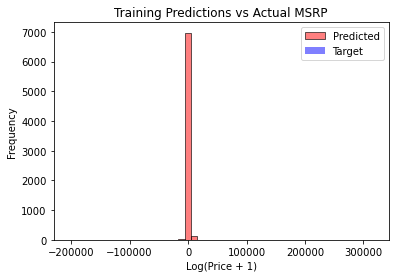

In [33]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_train.dot(w)

print('RMSE:',rmse(y_train,y_pred))

sns.histplot(y_pred, bins = 50, alpha = 0.5, color = 'red', label = 'Predicted')
sns.histplot(y_train, bins = 50, alpha = 0.5, color = 'blue', label = 'Target')
plt.legend()
plt.xlabel('Log(Price + 1)')
plt.ylabel('Frequency')
plt.title('Training Predictions vs Actual MSRP')
plt.show()
